# Deep Learning NN

##
---

In [1]:
import mlflow
import mlflow.pytorch
import os
TRACKING_DB = "sqlite:///D:/Project/Predictive_maintaince/Data/mlflow.db"
ARTIFACT_ROOT = "file:///D:/Project/Predictive_maintaince/mlartifacts"
mlflow.set_tracking_uri(TRACKING_DB)
experiment_name = "compressor_fault_model_v1"
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None:
    experiment_id = mlflow.create_experiment(
        name=experiment_name,
        artifact_location=ARTIFACT_ROOT
    )
else:
    experiment_id = experiment.experiment_id
mlflow.set_experiment(experiment_name)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,f1_score,accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


2026/02/06 21:20:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/06 21:20:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/06 21:20:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/06 21:20:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/06 21:20:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/06 21:20:56 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/06 21:20:57 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/06 21:20:57 INFO mlflow.store.db.utils: Updating database tables
2026/02/06 21:20:57 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/06 21:20:57 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/06 21:20:58 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/06 21:20:58 INFO alembic.runtime

In [2]:
val_df = pd.read_csv('../Data/processed/val_data.csv')
train_df = pd.read_csv('../Data/processed/train_data.csv')

In [3]:
FEATURES=["T_amb",
"T_evap_sat",
"P_dis_bar",
"P_suc_bar",
"P_comp_W",
"N_comp_Hz",
"delta_cond_evap",
"cooling_efficiency",
"P_dis_bar_rolling_mean",
"P_suc_bar_rolling_std",
"COP_diff",
"N_comp_Hz_diff",
"door_open",
"frost_level"]


In [4]:

def create_windows(df, window_size=60, stride=15):
    X, y = [], []

    for run_id in df['run_id'].unique():
        run_data = df[df['run_id'] == run_id]

        values = run_data[FEATURES].values
        label = run_data['fault_id'].iloc[0]

        for start in range(0, len(values) - window_size, stride):
            end = start + window_size

            X.append(values[start:end])
            y.append(label)

    return np.array(X), np.array(y)


##
---

## MLP

In [5]:
X_train, y_train = create_windows(train_df)
X_val, y_val     = create_windows(val_df)

print(X_train.shape)
print(y_train.shape)


(95679, 60, 14)
(95679,)


In [6]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat   = X_val.reshape(X_val.shape[0], -1)

print(X_train_flat.shape)


(95679, 840)


In [7]:
scaler = StandardScaler()

X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat   = scaler.transform(X_val_flat)

In [8]:
class FaultDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [9]:
class MLP_V1(nn.Module):
    def __init__(self, input_dim,num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            
            nn.Linear(256, num_classes),
        )
    def forward(self, x):
        return self.net(x)

In [10]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total_samples += y.size(0)

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples

    return avg_loss, acc


In [11]:
def eval_model(model,loader,device):
    model.eval()
    preds,targets = [],[]
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(y.cpu().numpy())
    return np.array(preds), np.array(targets)

In [12]:
torch.cuda.empty_cache()

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = FaultDataset(X_train_flat, y_train)
val_ds   = FaultDataset(X_val_flat, y_val)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256)


In [14]:
model = MLP_V1(
    input_dim=X_train_flat.shape[1],
    num_classes=len(np.unique(y_train))
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 30


✅ Saved best model
Epoch 01 | loss=0.6233 | train_acc=0.7194 | val_acc=0.7718
✅ Saved best model
Epoch 02 | loss=0.4403 | train_acc=0.7753 | val_acc=0.7770
Epoch 03 | loss=0.4097 | train_acc=0.7878 | val_acc=0.7748
✅ Saved best model
Epoch 04 | loss=0.3904 | train_acc=0.7966 | val_acc=0.7873
✅ Saved best model
Epoch 05 | loss=0.3870 | train_acc=0.7971 | val_acc=0.7899
Epoch 06 | loss=0.3787 | train_acc=0.8004 | val_acc=0.7703
Epoch 07 | loss=0.3693 | train_acc=0.8034 | val_acc=0.7718
Epoch 08 | loss=0.3677 | train_acc=0.8061 | val_acc=0.7665
Epoch 09 | loss=0.3625 | train_acc=0.8064 | val_acc=0.7780
✅ Saved best model
Epoch 10 | loss=0.3570 | train_acc=0.8096 | val_acc=0.7914
Epoch 11 | loss=0.3561 | train_acc=0.8103 | val_acc=0.7812
Epoch 12 | loss=0.3507 | train_acc=0.8116 | val_acc=0.7815
✅ Saved best model
Epoch 13 | loss=0.3473 | train_acc=0.8144 | val_acc=0.8003
Epoch 14 | loss=0.3429 | train_acc=0.8154 | val_acc=0.7816
Epoch 15 | loss=0.3406 | train_acc=0.8169 | val_acc=0.7839
E

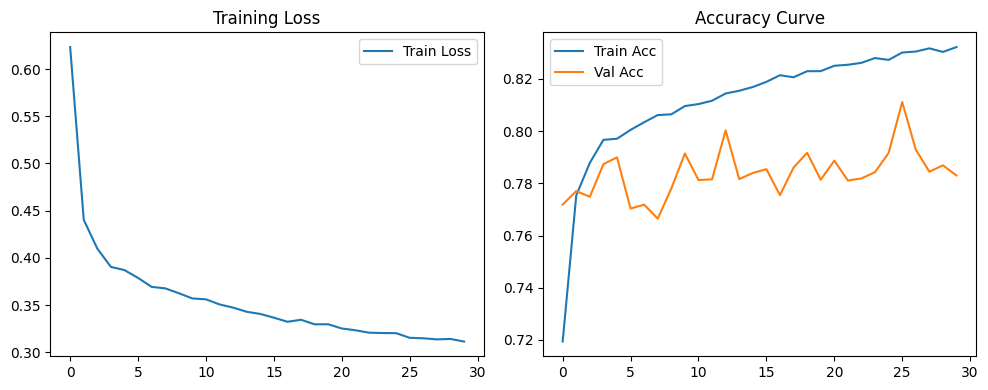

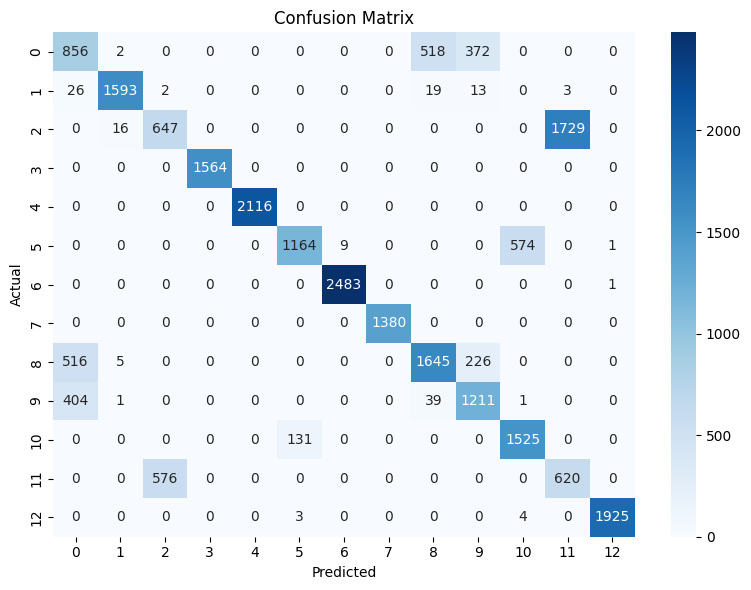

2026/02/06 21:26:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/06 21:26:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.10.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/06 21:26:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.10.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [15]:

best_val_acc = 0.0
best_model_path = "../Model/best_mlp.pt"

train_losses, train_accs, val_accs = [], [], []

with mlflow.start_run(run_name="DL_MLP_V1"):

    mlflow.log_param("model", "MLP_V1")
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("batch_size", 256)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("RUN_TYPE", device)

    for epoch in range(EPOCHS):

        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        preds, targets = eval_model(model, val_loader, device)
        val_acc = (preds == targets).mean()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print("✅ Saved best model")

        print(
            f"Epoch {epoch+1:02d} | "
            f"loss={train_loss:.4f} | "
            f"train_acc={train_acc:.4f} | "
            f"val_acc={val_acc:.4f}"
        )
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.savefig("../Plots/DL/MLP_learning_curve.png")
    plt.show()

    mlflow.log_artifact("../Plots/DL/MLP_learning_curve.png")
    
    cm = confusion_matrix(targets, preds)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("../Plots/DL/confusion_matrix.png")
    plt.show()

    mlflow.log_artifact("../Plots/DL/confusion_matrix.png")
    mlflow.pytorch.log_model(model, "dl_mlp_v1_model")
    mlflow.log_metric("accuracy", best_val_acc)





## 
---

## LSTM

In [16]:
X_train, y_train = create_windows(train_df)
X_val, y_val     = create_windows(val_df)

print(X_train.shape)
print(y_train.shape)


(95679, 60, 14)
(95679,)


In [17]:
# X_train, X_val are (N, 60, 14)

N, T, F = X_train.shape

# reshape to 2D just for scaling
X_train_2d = X_train.reshape(N*T, F)
X_val_2d   = X_val.reshape(X_val.shape[0]*T, F)

scaler = StandardScaler()
X_train_2d = scaler.fit_transform(X_train_2d)
X_val_2d   = scaler.transform(X_val_2d)

# reshape back to sequences
X_train_scaled = X_train_2d.reshape(N, T, F)
X_val_scaled   = X_val_2d.reshape(X_val.shape[0], T, F)


In [18]:
class FaultSeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)   # (N, T, F)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_ds = FaultSeqDataset(X_train_scaled, y_train)
val_ds   = FaultSeqDataset(X_val_scaled, y_val)


train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=128)


In [20]:
class LSTM_V1(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x: (batch, time, features)
        out, (h_n, c_n) = self.lstm(x)
        last_hidden = h_n[-1]        # (batch, hidden_dim)
        return self.classifier(last_hidden)


In [21]:
INPUT_DIM = X_train.shape[2]   # number of features
HIDDEN_DIM = 128
NUM_LAYERS = 2
NUM_CLASSES = len(np.unique(y_train))

model = LSTM_V1(
    input_dim=INPUT_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    num_classes=NUM_CLASSES
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [22]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()

    total_loss = 0
    total_correct = 0
    total_samples = 0

    for x, y in loader:
        x = x.to(device)   # (batch, time, features)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total_samples += y.size(0)

    return total_loss / total_samples, total_correct / total_samples


In [23]:
def eval_model(model, loader, device):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            preds.extend(logits.argmax(1).cpu().numpy())
            targets.extend(y.cpu().numpy())

    return np.array(preds), np.array(targets)


✅ Saved best LSTM model
Epoch 01 | loss=0.2531 | train_acc=0.8562 | val_acc=0.8090
Epoch 02 | loss=0.2534 | train_acc=0.8571 | val_acc=0.8077
✅ Saved best LSTM model
Epoch 03 | loss=0.2511 | train_acc=0.8587 | val_acc=0.8194
Epoch 04 | loss=0.2561 | train_acc=0.8583 | val_acc=0.7966
✅ Saved best LSTM model
Epoch 05 | loss=0.2527 | train_acc=0.8591 | val_acc=0.8196
✅ Saved best LSTM model
Epoch 06 | loss=0.2465 | train_acc=0.8630 | val_acc=0.8283
Epoch 07 | loss=0.2440 | train_acc=0.8641 | val_acc=0.8255
✅ Saved best LSTM model
Epoch 08 | loss=0.2459 | train_acc=0.8647 | val_acc=0.8342
Epoch 09 | loss=0.2423 | train_acc=0.8668 | val_acc=0.8214
Epoch 10 | loss=0.2417 | train_acc=0.8679 | val_acc=0.8092
Epoch 11 | loss=0.2393 | train_acc=0.8688 | val_acc=0.8255
Epoch 12 | loss=0.2373 | train_acc=0.8713 | val_acc=0.8186
Epoch 13 | loss=0.2373 | train_acc=0.8730 | val_acc=0.8182
Epoch 14 | loss=0.2364 | train_acc=0.8731 | val_acc=0.8289
Epoch 15 | loss=0.2324 | train_acc=0.8753 | val_acc=0.

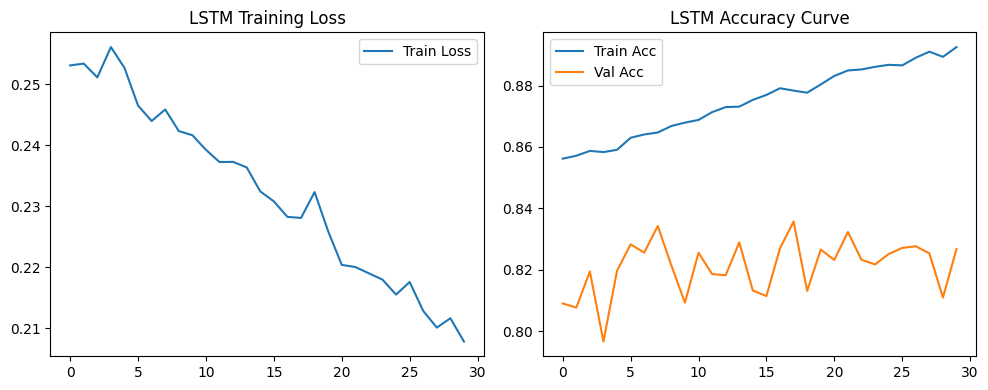

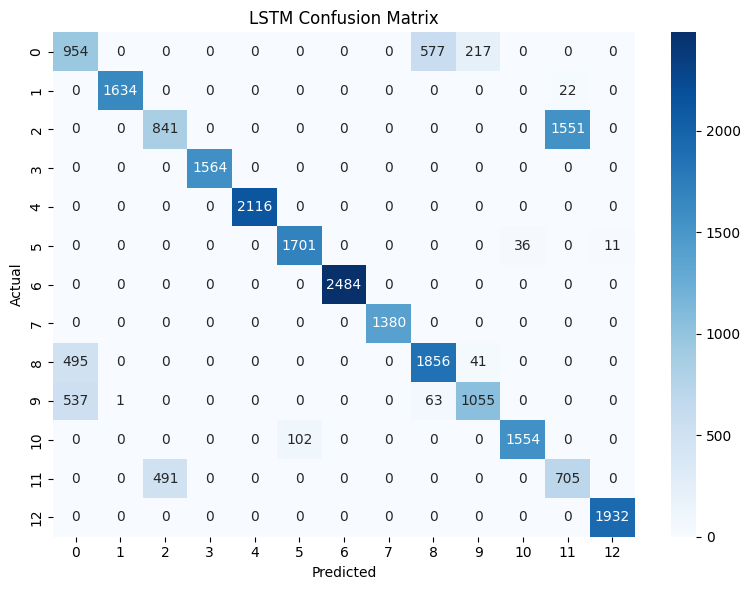

2026/02/06 21:45:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/06 21:45:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.10.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2026/02/06 21:45:49 WARNING mlflow.utils.requirements_utils: Found torch version (2.10.0+cu128) contains a local version label (+cu128). MLflow logged a pip requirement for this package as 'torch==2.10.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [25]:

EPOCHS = 30
best_val_acc = 0.0
best_model_path = "../Model/best_lstm.pt"

train_losses, train_accs, val_accs = [], [], []

with mlflow.start_run(run_name="DL_LSTM_V1"):

    mlflow.log_param("model", "LSTM_V1")
    mlflow.log_param("hidden_dim", HIDDEN_DIM)
    mlflow.log_param("num_layers", NUM_LAYERS)
    mlflow.log_param("batch_size", 128)
    mlflow.log_param("epochs", EPOCHS)
    mlflow.log_param("RUN_TYPE", device)

    for epoch in range(EPOCHS):

        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, criterion, device
        )

        preds, targets = eval_model(model, val_loader, device)
        val_acc = (preds == targets).mean()

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        mlflow.log_metric("train_loss", train_loss, step=epoch)
        mlflow.log_metric("train_acc", train_acc, step=epoch)
        mlflow.log_metric("val_acc", val_acc, step=epoch)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print("✅ Saved best LSTM model")

        print(
            f"Epoch {epoch+1:02d} | "
            f"loss={train_loss:.4f} | "
            f"train_acc={train_acc:.4f} | "
            f"val_acc={val_acc:.4f}"
        )
    model.load_state_dict(torch.load(best_model_path))
    model.eval()
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("LSTM Training Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.title("LSTM Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.savefig("lstm_learning_curve.png")
    plt.show()

    mlflow.log_artifact("lstm_learning_curve.png")
    
    cm = confusion_matrix(targets, preds)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("LSTM Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig("lstm_confusion_matrix.png")
    plt.show()

    mlflow.log_artifact("lstm_confusion_matrix.png")
    
    mlflow.pytorch.log_model(model, "lstm_v1_model")
    mlflow.log_metric("accuracy", best_val_acc)



